# Autoencoder

![AE](autoencoder.png)

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

In [3]:
import pathlib
mnist_root = f"{pathlib.Path.home()}/Projects/AI-ML/datasets/mnist"

In [4]:
batch_size = 128

train_dataset = torchvision.datasets.MNIST(mnist_root, train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(mnist_root, train=False, transform=transforms.ToTensor(), download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [28]:
import torch.nn.functional as F

class Encoder(nn.Module):

    def __init__(self, input_size, hidden_size, latent_dim) -> None:
        super().__init__()

        self.fc1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.fc2 = nn.Linear(in_features=hidden_size, out_features=latent_dim)

    def forward(self, x):
        hidden = F.relu(self.fc1(x))
        latent = self.fc2(hidden)
        return latent

class Decoder(nn.Module):

    def __init__(self, latent_dim, hidden_size, output_size) -> None:
        super().__init__()

        self.fc1 = nn.Linear(in_features=latent_dim, out_features=hidden_size)
        self.fc2 = nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, x):
        hidden = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(hidden))

class VAE(nn.Module):

    def __init__(self, input_size, hidden_size, latent_dim) -> None:
        super().__init__()

        self.encode = Encoder(input_size, hidden_size, latent_dim)
        self.decode = Decoder(latent_dim, hidden_size, input_size)
    
    def forward(self, X):
        latent = self.encode(X.view(X.size(0), -1)) # Flatten (batch_size, ...)
        output = self.decode(latent)
        return output, latent

In [29]:
def loss_function(constructed, original):
    return F.binary_cross_entropy(constructed, original.view(original.size(0), -1), reduction='sum')

In [34]:
def train(epoch, model, optimizer, print_every=100):
    model.train()
    train_loss = 0.0
    for i, (images, _) in enumerate(train_loader):
        constructeds, latent = model(images)
        loss = loss_function(constructeds, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if (i + 1) % print_every == 0:
            print(f"train epoch {epoch}, batch {i}/{len(train_loader)}, loss: {loss.item() / len(images):.3f}")

    train_loss /= len(train_dataset)
    print(f"====> Epoch {epoch}, average loss: {train_loss}")
    return train_loss


In [35]:
def test(model, print_every):
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for i, (images, _) in enumerate(test_loader):
            constructeds, latent = model(images)
            loss = loss_function(constructeds, images, latent)

            test_loss += loss.item()

            if (i + 1) % 100 == print_every:
                print(f"batch {i}/{len(test_loader)}, loss: {loss.item() / len(images):.3f}")

        test_loss /= len(test_dataset)
        print(f"====> average loss: {test_loss}")



In [36]:
image_size = 28 * 28
hidden_size = 400
latent_dim = 20
n_epoches = 10

model = VAE(image_size, hidden_size, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [37]:
for epoch in range(n_epoches):
    train(epoch, model, optimizer)

train epoch 0, batch 99/469, loss: 148.460
train epoch 0, batch 199/469, loss: 116.766
train epoch 0, batch 299/469, loss: 99.112
train epoch 0, batch 399/469, loss: 94.875
====> Epoch 0, average loss: 130.0737109375
train epoch 1, batch 99/469, loss: 83.211
train epoch 1, batch 199/469, loss: 82.323
train epoch 1, batch 299/469, loss: 83.397
train epoch 1, batch 399/469, loss: 77.380
====> Epoch 1, average loss: 82.35666451822917
train epoch 2, batch 99/469, loss: 74.968
train epoch 2, batch 199/469, loss: 74.698
train epoch 2, batch 299/469, loss: 74.255
train epoch 2, batch 399/469, loss: 78.479
====> Epoch 2, average loss: 77.05073079427083
train epoch 3, batch 99/469, loss: 73.113
train epoch 3, batch 199/469, loss: 74.261
train epoch 3, batch 299/469, loss: 74.352
train epoch 3, batch 399/469, loss: 71.320
====> Epoch 3, average loss: 74.30785414225261
train epoch 4, batch 99/469, loss: 74.664
train epoch 4, batch 199/469, loss: 74.777
train epoch 4, batch 299/469, loss: 73.665
t

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
def inference(images, model):
    model.eval()
    with torch.no_grad():
        constructeds, _ = model(images)
        return constructeds.view(images.shape[0], 1, 28, 28)

def infer_and_compare(image, model):
    constructeds = inference(image, model)
    return image.reshape((28, 28)), constructeds.reshape((28, 28))


image, constructeds = infer_and_compare(test_dataset[0][0], model)

image.shape, constructeds.shape

(torch.Size([28, 28]), torch.Size([28, 28]))

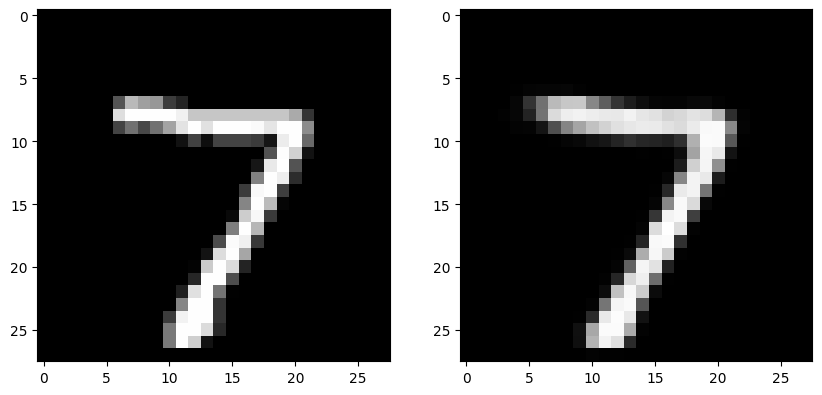

In [43]:
def plot_pair(image, constructed):
    fig = plt.figure(figsize=(10, 5))
    _ = fig.add_subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    _ = fig.add_subplot(1, 2, 2)
    plt.imshow(constructed, cmap='gray')
    plt.show()

plot_pair(image, constructeds)

In [59]:
def latent_sampling(n_samples):
    latent_samples = torch.randn(n_samples, latent_dim)
    with torch.no_grad():
        constructeds = model.decode(latent_samples)
        return constructeds.view(-1, 1, 28, 28)

constructeds = latent_sampling(10)
constructeds.shape

torch.Size([10, 1, 28, 28])

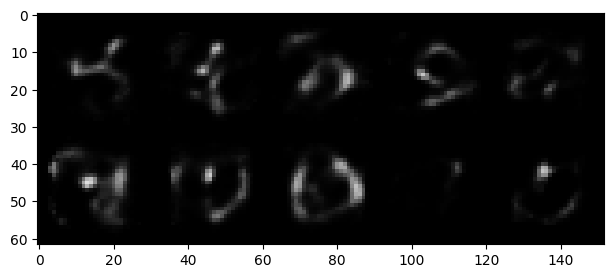

In [62]:
from torchvision.utils import make_grid

def plot_samples(constructeds):
    plt.figure(figsize=(10, 3))
    plt.imshow(make_grid(constructeds, nrow=5).permute(1, 2, 0), cmap='gray')
    plt.show()

plot_samples(constructeds)

# Latent Space

In [63]:
from tqdm.autonotebook import tqdm

latent_space = []
for image, label in tqdm(test_dataset):

    model.eval()
    with torch.no_grad():
        latent = model.encode(image.view(-1))

    latent = latent.flatten().numpy()
    sample = {f"Encoded_{i}": encoded for i, encoded in enumerate(latent)}
    sample['label'] = label
    latent_space.append(sample)

100%|██████████| 10000/10000 [00:00<00:00, 13051.34it/s]


In [64]:
import pandas as pd

latent_space = pd.DataFrame(latent_space)
latent_space['label'] = latent_space['label'].astype(str)

latent_space.head()

,Encoded_0,Encoded_1,Encoded_2,Encoded_3,Encoded_4,Encoded_5,Encoded_6,Encoded_7,Encoded_8,Encoded_9,...,Encoded_11,Encoded_12,Encoded_13,Encoded_14,Encoded_15,Encoded_16,Encoded_17,Encoded_18,Encoded_19,label
0,3.564027,9.547861,4.886412,2.349909,-2.082876,3.943501,1.381360,0.767944,-3.452310,4.347052,...,-1.601610,-2.820389,2.156797,-3.622727,-2.196494,-2.595282,-4.467386,2.416487,-0.582435,7
1,-1.871639,0.601932,-1.138755,-8.497347,-3.201203,0.182974,-3.710460,0.526193,1.539595,-5.307961,...,10.227912,4.511192,-2.595778,0.313579,6.070636,0.408089,-0.382847,2.073765,4.760406,2
2,-2.269649,-1.664141,-3.437259,0.067495,-5.931700,-0.180652,0.828445,-5.487751,0.766849,3.694088,...,0.304487,-0.165287,5.499488,-3.388476,2.541520,0.517135,-2.841830,3.871514,3.932166,1
3,7.479793,5.889568,1.317137,-4.373565,-1.837871,4.464717,-7.121642,-2.167509,-7.180558,-2.917017,...,10.705716,-2.198392,2.135594,2.829084,0.116584,0.398829,0.844832,-2.144519,2.414562,0
4,2.106921,2.128837,-0.774967,1.692310,6.157526,7.775589,-0.985861,3.771013,-0.245877,2.201168,...,5.342408,-4.352204,1.036037,2.734861,1.571119,-0.313267,-2.706196,0.178901,-0.763242,4


In [65]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
digits_embedded = tsne.fit_transform(latent_space.drop(['label'],axis=1))

In [70]:
digits_embedded[:5]

array([[ 53.566696,  -8.283025],
       [-31.166576, -56.27377 ],
       [ 46.01439 , -36.329643],
       [-51.543915,  24.034119],
       [ 19.249554,  64.00769 ]], dtype=float32)

In [74]:
latent_space['label']

0       7
1       2
2       1
3       0
4       4
       ..
9995    2
9996    3
9997    4
9998    5
9999    6
Name: label, Length: 10000, dtype: object

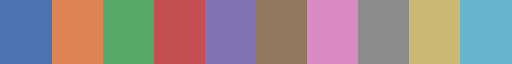

In [81]:
import numpy as np

import seaborn as sns

from matplotlib.colors import ListedColormap
import matplotlib as mpl

PALETTE = sns.color_palette('deep', n_colors=10)
CMAP = ListedColormap(PALETTE.as_hex())

CMAP

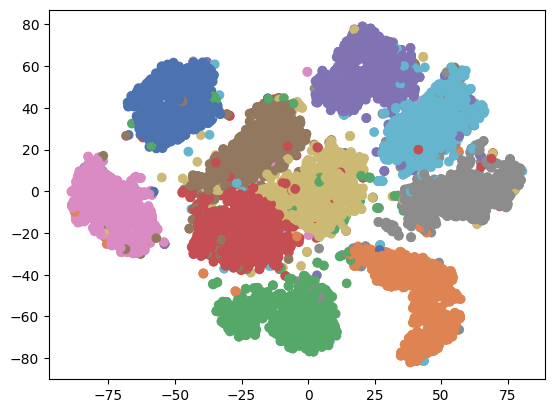

In [84]:


plt.scatter(digits_embedded[:, 0], digits_embedded[:, 1],
            c=latent_space['label'].values.astype(int), cmap=CMAP)
                      
plt.show()